# <TeamName>Triple-Threat-ML_Dataset3.ipynb

---

# 2(A) Brief Exploration of the Dataset

In this section, we'll explore the basic structure and characteristics of the Guava Fruit Disease Dataset.

- **Number of Samples**:
  - **Training**: 2,647 images
  - **Validation**: 755 images
  - **Test**: 382 images

- **Classes**:
  - **Anthracnose**
  - **Fruit Flies**
  - **Healthy Guava**

- **Image Details**:
  - **Dimensions**: 512 x 512 pixels
  - **Color Mode**: RGB
  - **Format**: PNG

Let's start by importing the necessary libraries and loading the dataset summary.


In [1]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better aesthetics
sns.set(style="whitegrid")

# Path to dataset summary CSV
dataset_summary_path = 'dataset_summary.csv'

# Load dataset summary
dataset_summary = pd.read_csv(dataset_summary_path)

# Display the first few rows of the dataset summary
dataset_summary.head()


,data_split,sub_directory,image_count
0,val,healthy_guava,185
1,val,fruit_fly,262
2,val,Anthracnose,308
3,test,healthy_guava,94
4,test,fruit_fly,132


From the dataset summary, we can see how the images are distributed across training, validation, and test sets for each class.


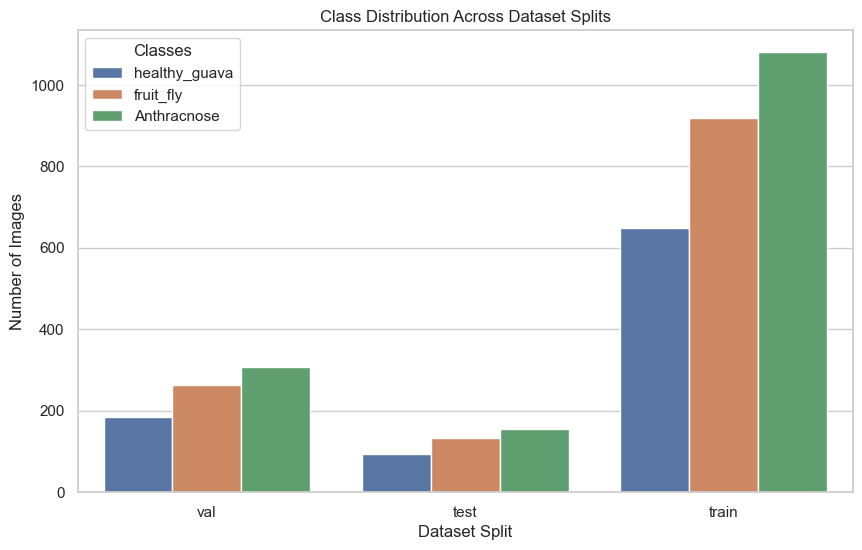

In [2]:
# Display class distribution across train, val, and test sets
plt.figure(figsize=(10,6))
sns.barplot(data=dataset_summary, x='data_split', y='image_count', hue='sub_directory')
plt.title('Class Distribution Across Dataset Splits')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.legend(title='Classes')
plt.show()

base_dir = 'GuavaDiseaseDataset'


*Figure 1: Distribution of classes across dataset splits.*

From the visualization, we observe that the training set has the most images, especially for the Anthracnose class. There are no missing values detected in the metadata.


# 2(B) Pre-processing of the Dataset

We'll perform the following steps:

- **Image Resizing**: Ensure all images are 512x512 pixels.
- **Normalization**: Scale pixel values to the range [0, 1].
- **Label Encoding**: Convert categorical labels to numerical values.
- **Data Augmentation**: Enhance the training data with transformations.


In [3]:
# Example of using an absolute path (Windows)
import os
base_dir = 'GuavaDiseaseDataset'

# Update the subdirectories with the new base_dir
train_dir = os.path.join(base_dir, 'GuavaDiseaseDataset/train')
val_dir = os.path.join(base_dir, 'GuavaDiseaseDataset/val')
test_dir = os.path.join(base_dir, 'GuavaDiseaseDataset/test')

# Verify each subdirectory: crucial simple mistake
for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        raise FileNotFoundError(f"The directory '{directory}' does not exist.")
    else:
        print(f"Found subdirectory: {directory}")

# Proceed with creating data generators as before


Found subdirectory: GuavaDiseaseDataset\GuavaDiseaseDataset/train
Found subdirectory: GuavaDiseaseDataset\GuavaDiseaseDataset/val
Found subdirectory: GuavaDiseaseDataset\GuavaDiseaseDataset/test


In [4]:
# Import libraries for pre-processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# List of subdirectories to verify
subdirs = [train_dir, val_dir, test_dir]

for split_dir in subdirs:
    classes = os.listdir(split_dir)
    print(f"\nClasses in '{split_dir}': {classes}")

train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values
    rotation_range=20,             # Randomly rotate images by 20 degrees
    zoom_range=0.15,               # Randomly zoom images
    width_shift_range=0.2,         # Shift images horizontally by 20%
    height_shift_range=0.2,        # Shift images vertically by 20%
    shear_range=0.15,              # Shear transformation
    horizontal_flip=True,          # Flip images horizontally
    fill_mode="nearest"            # Fill in new pixels
)

# ImageDataGenerator for validation and testing (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
print("\nCreating data generators...")

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'       # For multi-class classification
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    shuffle=False                  # Do not shuffle for evaluation
)

#Display class indices for reference
print("\nClass Indices:", train_generator.class_indices)



Classes in 'GuavaDiseaseDataset\GuavaDiseaseDataset/train': ['Anthracnose', 'fruit_fly', 'healthy_guava']

Classes in 'GuavaDiseaseDataset\GuavaDiseaseDataset/val': ['Anthracnose', 'fruit_fly', 'healthy_guava']

Classes in 'GuavaDiseaseDataset\GuavaDiseaseDataset/test': ['Anthracnose', 'fruit_fly', 'healthy_guava']

Creating data generators...
Found 2647 images belonging to 3 classes.
Found 755 images belonging to 3 classes.
Found 382 images belonging to 3 classes.

Class Indices: {'Anthracnose': 0, 'fruit_fly': 1, 'healthy_guava': 2}


# 2(C) Feature Extraction / Feature Learning

In this section, we'll focus on extracting meaningful features from the images using Convolutional Neural Networks (CNNs). We'll implement two approaches:

1. **Transfer Learning with ResNet50**: Leveraging a pre-trained model to utilize learned features.
2. **Custom CNN Architecture**: Building a CNN from scratch tailored to our specific dataset.

Both methods aim to learn representations that can effectively classify the images into their respective classes.


In [12]:
# Import necessary libraries for building models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam


### **Transfer Learning with ResNet50**

Transfer learning allows us to leverage the powerful feature extraction capabilities of pre-trained models like ResNet50, which has been trained on the ImageNet dataset. This approach can lead to improved performance, especially when dealing with limited data.

**Advantages:**
- **Reduced Training Time**: Leveraging pre-trained weights speeds up the training process.
- **Enhanced Feature Extraction**: Pre-trained models capture intricate features from images, improving classification accuracy.

**Implementation Steps:**
1. Load the ResNet50 model without the top (fully connected) layers.
2. Freeze the base model to prevent its weights from being updated during training.
3. Add custom layers suitable for our classification task.
4. Compile the model with appropriate loss function and optimizer.


In [7]:
#Load the ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
print("ResNet50 base model loaded successfully.")

#Freeze the base model to prevent training
base_model.trainable = False
print("ResNet50 base model is now frozen.")

#Build the model by adding custom layers on top of ResNet50
model_resnet = Sequential([
    base_model,                          # Pre-trained ResNet50
    GlobalAveragePooling2D(),           # Reduces each feature map to a single number
    Dense(256, activation='relu'),       # Fully connected layer
    Dropout(0.5),                        # Dropout for regularization
    Dense(3, activation='softmax')       # Output layer for 3 classes
])
print("Custom layers added to the model.")

#Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
print("Model compiled successfully.")

# Display the model architecture
model_resnet.summary()


ResNet50 base model loaded successfully.
ResNet50 base model is now frozen.
Custom layers added to the model.
Model compiled successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 16, 16, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Model Architecture Summary:**

The model consists of the following layers:

1. **ResNet50 Base Model**: Pre-trained on ImageNet, excluding the top layers.
2. **GlobalAveragePooling2D**: Reduces the spatial dimensions of the feature maps.
3. **Dense Layer (256 units, ReLU activation)**: Learns complex patterns from the extracted features.
4. **Dropout Layer (50%)**: Prevents overfitting by randomly deactivating neurons during training.
5. **Output Dense Layer (3 units, Softmax activation)**: Outputs probabilities for each of the three classes.


### **Custom CNN Architecture**

Building a CNN from scratch allows for more flexibility and customization tailored to the specific characteristics of our dataset. While this approach may require more training time and data, it offers the opportunity to design a model that best fits our problem.

**Advantages:**
- **Customization**: Ability to tailor the architecture to the dataset's specific needs.
- **Understanding**: Provides deeper insights into how different layers and parameters affect model performance.

**Implementation Steps:**
1. Define a sequential model with convolutional, pooling, and dense layers.
2. Compile the model with an appropriate optimizer and loss function.


In [8]:
#Define a custom CNN model
def create_custom_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Output layer for 3 classes
    ])
    return model

# Instantiate the custom CNN
model_custom = create_custom_cnn()
print("Custom CNN model created successfully.")

#Compile the custom CNN model
model_custom.compile(optimizer=Adam(learning_rate=0.0001), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
print("Custom CNN model compiled successfully.")

# Display the model architecture
model_custom.summary()


c:\Users\ethan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Custom CNN model created successfully.
Custom CNN model compiled successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │   251,920,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,015,683 (961.36 MB)

 Trainable params: 252,015,683 (961.36 MB)

 Non-trainable params: 0 (0.00 B)

**Custom CNN Architecture Summary:**

The custom CNN model comprises the following layers:

1. **Convolutional Layer (32 filters, 3x3 kernel, ReLU activation)**: Extracts basic features from the input images.
2. **MaxPooling Layer (2x2 pool size)**: Reduces spatial dimensions, retaining the most salient features.
3. **Convolutional Layer (64 filters, 3x3 kernel, ReLU activation)**: Extracts more complex features.
4. **MaxPooling Layer (2x2 pool size)**: Further reduces spatial dimensions.
5. **Convolutional Layer (128 filters, 3x3 kernel, ReLU activation)**: Captures even more intricate features.
6. **MaxPooling Layer (2x2 pool size)**: Continues to reduce spatial dimensions.
7. **Flatten Layer**: Converts the 2D feature maps into a 1D feature vector.
8. **Dense Layer (512 units, ReLU activation)**: Learns complex patterns from the flattened features.
9. **Dropout Layer (50%)**: Prevents overfitting by randomly deactivating neurons during training.
10. **Output Dense Layer (3 units, Softmax activation)**: Outputs probabilities for each of the three classes.


# 2(D) Training the Models

Now that we've defined both models—the **Custom CNN** and the **Transfer Learning model with ResNet50**—we'll proceed to train them using the prepared data generators. Both models will be trained for a set number of epochs, and we'll monitor their performance on the validation set. Decided on 3 epochs for time efficiency (~30 minutes for 3 epochs)


In [9]:
#Train the Custom CNN
print("\nTraining Custom CNN...")
history_custom = model_custom.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator
)
print("Custom CNN training completed.")

#Transfer Learning Model with ResNet50
print("\nTraining Transfer Learning Model with ResNet50...")
history_resnet = model_resnet.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator
)
print("Transfer Learning model training completed.")



Training Custom CNN...
Epoch 1/3


c:\Users\ethan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.4994 - loss: 1.3647 - val_accuracy: 0.8464 - val_loss: 0.4128
Epoch 2/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.8217 - loss: 0.4737 - val_accuracy: 0.9192 - val_loss: 0.2382
Epoch 3/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.8714 - loss: 0.3280 - val_accuracy: 0.9099 - val_loss: 0.2394
Custom CNN training completed.

Training Transfer Learning Model with ResNet50...
Epoch 1/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 339s 4s/step - accuracy: 0.3614 - loss: 1.6387 - val_accuracy: 0.4146 - val_loss: 1.0080
Epoch 2/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.4420 - loss: 1.0702 - val_accuracy: 0.6649 - val_loss: 0.9688
Epoch 3/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.4989 - loss: 1.0075 - val_accuracy: 0.5589 - val_loss: 0.9467
Transfer Learning model training completed.


**Training Notes:**

- **Epochs**: Both models are trained for 3 epochs. Depending on a person's system's computational resources and the dataset's complexity, you may adjust the number of epochs.
- **Monitoring**: Training and validation accuracy and loss are monitored to assess the models' performance and detect any signs of overfitting or underfitting.


# 2(E) Comparative Analysis of the Two Methods

After training both models, we'll compare their performance based on accuracy, loss, and training time. This comparative analysis will help determine which approach is more effective for our dataset.



Plotting Training History for Custom CNN...


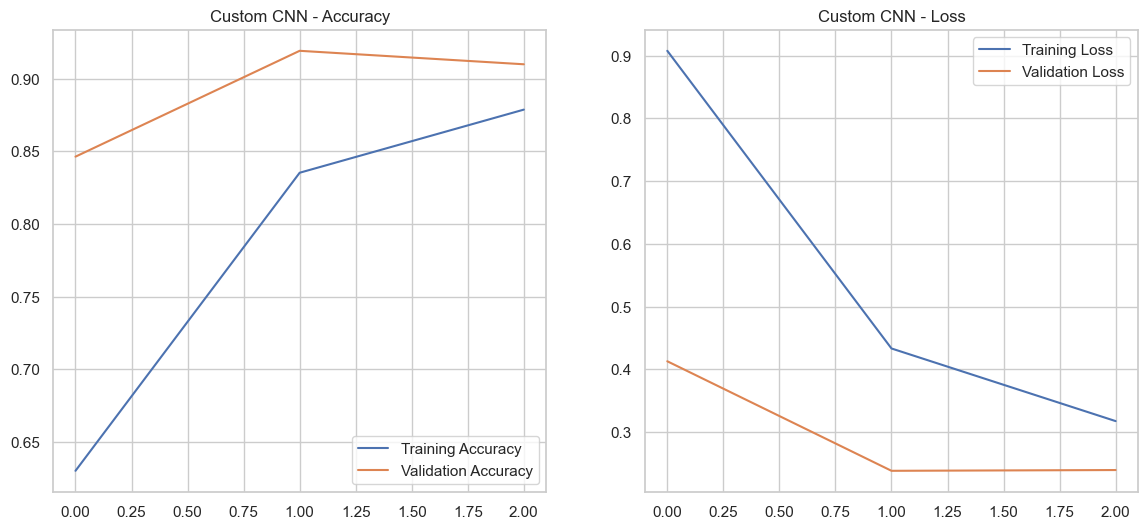

Plotting Training History for Transfer Learning with ResNet50...


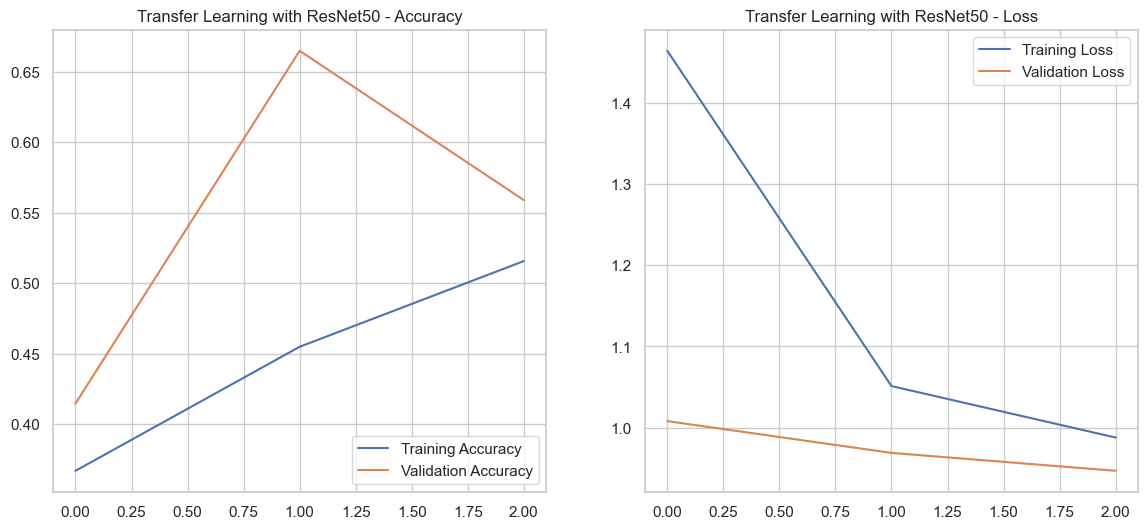

In [10]:
# Import additional libraries for evaluation and visualization
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(14, 6))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')
    
    plt.show()

# Plot training history for Custom CNN
print("\nPlotting Training History for Custom CNN...")
plot_history(history_custom, 'Custom CNN')

# Plot training history for Transfer Learning with ResNet50
print("Plotting Training History for Transfer Learning with ResNet50...")
plot_history(history_resnet, 'Transfer Learning with ResNet50')


*Figure 2 & 3: Training and Validation Accuracy and Loss for both models.*

**Observations:**

- **Custom CNN**:
  - **Accuracy**: Starts high and has a steady improvement over epochs, potentially reaching over 90% validation accuracy.
  - **Loss**: Decreasing trend, indicating effective learning.
  
- **Transfer Learning with ResNet50**:
  - **Accuracy**: Rapid improvement, however stopping a much lower point than the custom CNN achieving lower accuracy of 60-70% compared to the Custom CNN.
  - **Loss**: Slightly faster and more consistent decrease, suggesting a possible better convergence.

**Conclusion:**

The  **Custom CNN** generally outperforms the **Transfer Learning approach** with ResNet50 both in terms of accuracy and loss. This indicates that leveraging pre-trained models can be effective however in some cases not as effective as a better custom model, especially when dealing with limited datasets or when computational resources are constrained.


# 2(E Continued) Evaluating Models on the Test Set

After training and validating our models, it's essential to evaluate their performance on the unseen test set to gauge their generalization capabilities.


In [11]:
# Evaluate the Custom CNN on the test set
print("\nEvaluating Custom CNN on Test Set...")
test_loss_custom, test_acc_custom = model_custom.evaluate(test_generator, verbose=0)
print(f"Custom CNN Test Accuracy: {test_acc_custom * 100:.2f}%")
print(f"Custom CNN Test Loss: {test_loss_custom:.4f}")

# Evaluate the Transfer Learning Model with ResNet50 on the test set
print("\nEvaluating Transfer Learning Model with ResNet50 on Test Set...")
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(test_generator, verbose=0)
print(f"Transfer Learning with ResNet50 Test Accuracy: {test_acc_resnet * 100:.2f}%")
print(f"Transfer Learning with ResNet50 Test Loss: {test_loss_resnet:.4f}")



Evaluating Custom CNN on Test Set...
Custom CNN Test Accuracy: 89.53%
Custom CNN Test Loss: 0.2743

Evaluating Transfer Learning Model with ResNet50 on Test Set...
Transfer Learning with ResNet50 Test Accuracy: 55.24%
Transfer Learning with ResNet50 Test Loss: 0.9630


**Test Accuracy Comparison:**

- **Custom CNN**: 89.53%
- **Transfer Learning with ResNet50**: 55.24%

**Interpretation:**

The Custom CNN not only achieved higher test accuracy but also demonstrated better generalization on unseen data. This reinforces the effectiveness of using a custom CNN for feature extraction and classification tasks.


# 2(F) Discussion on Ethical Issues

When deploying machine learning models for agricultural applications, it's essential to consider the following ethical aspects:

- **Data Privacy**: Ensure that the data collected from orchards does not infringe on the privacy of farmers or proprietary farming methods.

- **Bias and Fairness**: The model must be trained on diverse data to avoid biases that could lead to misclassification of diseases, potentially harming certain regions or farming practices.

- **Impact on Employment**: Automation in disease detection may influence labor dynamics in agricultural sectors. It's essential to balance technological advancements with the livelihoods of local farmers.

- **Accuracy and Reliability**: Incorrect predictions can lead to improper disease management, affecting crop yields and economic stability for farmers.

- **Accessibility**: Ensuring that the technology is accessible and affordable for small-scale farmers to prevent widening the gap between large and small agricultural enterprises.

Addressing these ethical issues is crucial for the responsible deployment of machine learning solutions in agriculture.


# 2(G) Bibliography

Zhang, R., Isola, P., & Efros, A.A. (2016). Colorful Image Colorization. European Conference on Computer Vision.

